In [1]:
import os, sys
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import numpy as np
import qutip as qt
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import netket as nk
import jax.numpy as jnp
import flax.linen as nn
import optax

import copy

import netket_pro as nkp
import netket_pro.jumps as nkj

from netket.operator.spin import sigmax,sigmay,sigmaz,sigmam,sigmap
from netket.vqs import MCState, FullSumState

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
def probabilities_measurement(vstate, c_ops, key):
    key,subkey = jax.random.split(key)    
    delta_pm   = jnp.array([vstate.expect((c.H@c).collect()).real().mean for c in c_ops])
    c_op_idx   = jax.random.choice(subkey, len(c_ops), p=delta_pm/sum(delta_pm))
    c_op       = c_ops[c_op_idx]
    spin_idx   = c_op.acting_on[0][0]
    scaling    = c_op.operators[0].data[0].item()
    _, col_nz  = c_op.operators[0].nonzero()
    is_sigmaup = col_nz[0] 
    return spin_idx, scaling, is_sigmaup, key


def trotterized_dynamics_with_jumps(Hod, g, J, c_ops, e_ops, variational_state, dt, tf, key_do_jump, key_which_jump,
                                    to_zero=0., save_states=False, track_infidelity=False, do_jumps=True, cv_coeff=None,
                                    n_iter=100, optimizer=nk.optimizer.Adam(learning_rate=0.01), target_infidelity=None):
    psi = variational_state

    if isinstance(psi, FullSumState):
        phi = FullSumState(psi.hilbert, psi.model)
        phi.variables  = psi.variables
    else:
        phi = MCState(psi.sampler, psi.model, n_samples=psi.n_samples)
        phi.variables  = psi.variables
        
    # Create hermitian propagation handles
    i_zz   = jnp.array([gg[0] for gg in g.edges()])
    j_zz   = jnp.array([gg[1] for gg in g.edges()])
    il_zz  = nkj.operations.lin_to_tril_index(i_zz,j_zz)
    ϕ_zz   = jnp.ones_like(il_zz) * J * dt/2

    # Create non-hermitian propagation handles
    c_tot = sum([c.H@c for c in c_ops])
    sites = jnp.array([acting[0] for acting in c_tot.acting_on])
    vals  = jnp.array([jnp.exp(-0.5 * dt/2 * jnp.diag(cop.A)) for cop in c_tot.operators])

    # Create integration handles
    t_list = jnp.arange(0, tf, dt)
    expect = [np.zeros(len(t_list)) for _ in e_ops]
    if save_states: 
        states = []
    if track_infidelity:
        infidelity_mean = np.zeros((len(t_list), n_iter))
        infidelity_var  = np.zeros((len(t_list), n_iter))
    
    ### TIME EVOLUTION
    for i in tqdm(range(len(t_list))):
        
        # Save state and expectation values
        for j,e in enumerate(e_ops):
            expect[j][i] = psi.expect(e).real().mean.item()
        if save_states:
            if isinstance(psi, FullSumState):
                state = FullSumState(psi.hilbert, psi.model)
                state.variables = psi.variables
                states.append(state)
            else:
                state = MCState(psi.sampler, psi.model, n_samples=psi.n_samples)
                state.variables = psi.variables
                states.append(state)
                
        ## Trotterized non-hermitian evolution
        # Diagonal evolution
        nkj.operations.apply_diagop(psi, sites, vals[:,0], vals[:,1])
        nkj.operations.apply_zz(psi, ϕ_zz, il_zz)
        phi.variables = psi.variables

        # Off-diagonal evolution
        logger = nk.logging.RuntimeLog()
        te = nkp.driver.MidpointInfidelityOptimizer(
            phi,
            optimizer,
            variational_state=psi,
            H = Hod,
            dt = dt,
            cv_coeff=cv_coeff,
        )
        te.run(n_iter=n_iter, out=logger, show_progress=False, target_infidelity=target_infidelity)
        phi.variables = psi.variables
        
        if track_infidelity:
            cut = logger.data["Infidelity"]["Mean"].size
            infidelity_mean[i,:cut] = jnp.abs(logger.data["Infidelity"]["Mean"])
            infidelity_var[i,:cut]  = logger.data["Infidelity"]["Variance"]
        
        # Diagonal evolution
        nkj.operations.apply_diagop(psi, sites, vals[:,0], vals[:,1])
        nkj.operations.apply_zz(psi, ϕ_zz, il_zz)
        phi.variables = psi.variables
        
        # Jump 
        key_do_jump, subkey = jax.random.split(key_do_jump)
        delta_p = psi.expect(c_tot).real().mean.item() * dt if do_jumps else 0
        
        if delta_p > jax.random.uniform(subkey):
            spin_idx, scaling, is_sigmaup, key_which_jump = probabilities_measurement(psi, c_ops, key_which_jump)
            if is_sigmaup:
                nkj.operations.apply_sigmap(psi, spin_idx, scale=scaling, to_zero=to_zero)
            else:
                nkj.operations.apply_sigmam(psi, spin_idx, scale=scaling, to_zero=to_zero)
            phi.variables  = psi.variables
    
    if save_states:
        if track_infidelity:
            return expect, states, infidelity_mean, infidelity_var
        return expect, states
    else:
        if track_infidelity:
            return expect, infidelity_mean, infidelity_var
        return expect

In [3]:
# INTEGRATOR
def exact_integrator(psi0, dt, tf, c_ops, e_ops, f_H_exact_step, key_do_jump, key_which_jump, do_jumps=True):
    psi  = psi0
    ctot = sum([c.dag()*c for c in c_ops])
    tl   = np.arange(0, tf, dt)
    X    = 1 if do_jumps else 0
    
    expect = [np.zeros(len(tl)) for _ in e_ops]
    psi_list = []
    
    for i,t in tqdm(enumerate(tl)):
        psi_list.append(psi/psi.norm())
        for j,e in enumerate(e_ops):
            expect[j][i] = np.real(qt.expect(e, psi/psi.norm()))
    
        psi = f_H_exact_step(psi) #/ np.sqrt(1-delta_p)
    
        key_do_jump, subkey = jax.random.split(key_do_jump)
        delta_p = qt.expect(ctot, psi/psi.norm()) * dt
        
        if X * delta_p > jax.random.uniform(subkey):
            psi_norm = psi/psi.norm()
            delta_pm = np.array([qt.expect(c.dag()*c, psi_norm) for c in c_ops]) * dt
            
            key_which_jump, subkey = jax.random.split(key_which_jump)
            idx = jax.random.choice(subkey, len(c_ops), p=delta_pm/delta_p)
            psi = c_ops[idx] * psi #/ np.sqrt(delta_pm[idx]/dt)
            
            print("Jump (idx={}) at time {}".format(idx, t))
        
    return tl, expect, psi_list

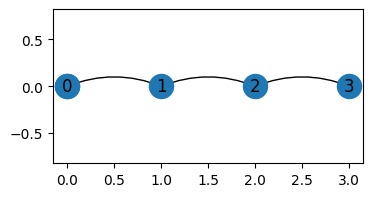

In [4]:
# Define geometry
Lx, Ly = 4, 2
g  = nk.graph.Chain(Lx, pbc=False)
g.draw(figsize=(4,2))
N  = g.n_nodes
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

γ = 1
h = 0.3
J = -1.

H_diag = sum([J * sigmaz(hi, i) * sigmaz(hi, j) for i,j in g.edges()]) 
H_offd = sum([h * sigmax(hi, i) for i in g.nodes()])
H      = H_diag + H_offd
c_ops  = [np.sqrt(γ) * sigmam(hi,i) for i in g.nodes()]
e_ops  = [sum([sigmaz(hi,i) for i in g.nodes()])/N, sum([sigmax(hi,i) for i in g.nodes()])/N] + [sigmaz(hi,i) for i in g.nodes()]

In [5]:
dt = 0.1
tf = 1.0
ts = jnp.arange(0, tf, dt)

In [6]:
model = nkj.networks.RBM(alpha=1, param_dtype=complex)
model = nkj.networks.ExtendedNetwork(model)
vgs = nk.vqs.FullSumState(hi, model)

print("Ground state energy: ", H_offd.to_qobj().groundstate()[0])

lr = 0.01
n_iter = 1000
optimizer = optax.nadam(learning_rate=lr)
gs_driver = nk.driver.VMC(H_offd, optimizer, variational_state=vgs)
gs_driver.run(n_iter, out=nk.logging.RuntimeLog(), show_progress=True);

Ground state energy:  -1.2


100%|██████████| 1000/1000 [00:00<00:00, 1416.54it/s, Energy=-1.200e+00-2.517e-17j ± 0.000e+00 [σ²=2.939e-05]]


In [7]:
# Define the variational state
model = nkj.networks.RBM(alpha=1, param_dtype=complex)
model = nkj.networks.ExtendedNetwork(model, param_dtype=complex, kernel_two_body_init=nn.initializers.normal(), delta_dw_init=nn.initializers.normal(), delta_up_init=nn.initializers.normal())
sampler = nk.sampler.ExactSampler(hi) #nk.sampler.MetropolisLocal(hilbert=hi, n_chains_per_rank_or_device=16)
psi = nk.vqs.FullSumState(hi, model) #nk.vqs.MCState(sampler=sampler, model=model, n_samples=1008*2) 
psi.parameters = vgs.parameters
psi.variables  = vgs.variables

# Optimization parameters
lr = 5e-2
n_iter = 1000
schedule = optax.linear_schedule(lr, 1e-3, 1000, transition_begin=600) 
optimizer = optax.adabelief(learning_rate=schedule,)

# Define keys for random number generation    
key_do_jump = jax.random.PRNGKey(9)
key_which_jump = jax.random.PRNGKey(69)

# Define handles for exact evolution
H_qo     = H.to_qobj()
Heff_qo  = (H - 1j/2 * sum([c.H@c for c in c_ops])).to_qobj()
c_ops_qo = [c.to_qobj() for c in c_ops]
e_ops_qo = [e.to_qobj() for e in e_ops]
psi0_qo  = psi.to_qobj()

exp_Heff_dt = (-1j*Heff_qo*dt).expm()
def f_H_exact_step(psi):
    return exp_Heff_dt*psi

# Define additional parameters for the integrator
cv_coeff = -0.5
to_zero  = 1e-12
target_infidelity = 1e-9

# Evolve
_, expect_ED, psi_ED = exact_integrator(psi0_qo, dt, tf, c_ops_qo, e_ops_qo, f_H_exact_step, key_do_jump, key_which_jump, do_jumps=True)

expect, states, infidelity_mean, infidelity_var = trotterized_dynamics_with_jumps(H_offd, g, J, c_ops, e_ops, psi, dt, tf, key_do_jump, key_which_jump,
                                         to_zero=to_zero, target_infidelity=target_infidelity, cv_coeff=cv_coeff, save_states=True,
                                         n_iter=n_iter, optimizer=optimizer, track_infidelity=True, do_jumps=True)

10it [00:00, 64.79it/s]


Jump (idx=3) at time 0.30000000000000004
Jump (idx=2) at time 0.7000000000000001


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


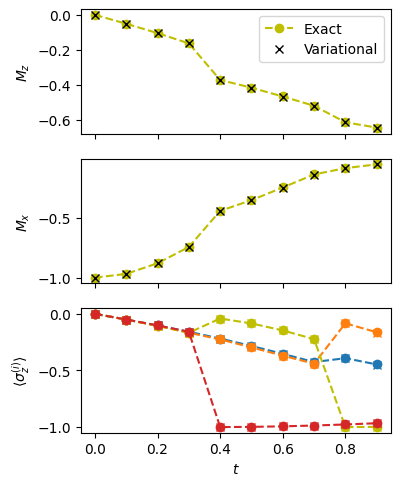

In [8]:
fig, ax = plt.subplots(3,1, figsize=(4.,5.5), sharex=True)

for i in range(2):
    ax[i].plot(ts, expect_ED[i], "yo--", label="Exact")
    ax[i].plot(ts, expect[i]   , "kx"  , label="Variational")
    # ax[i].set_ylim(-1.1,1.1)

c = ["C0", "C1", "y", "C3"]
for i in range(2,len(expect)):
    ax[-1].plot(ts, expect_ED[i], "o--", c=c[i-2], label="Exact")
    ax[-1].plot(ts, expect[i]   , "x"  , c=c[i-2], label="Variational")

ax[+0].set_ylabel(r"$M_z$")
ax[+1].set_ylabel(r"$M_x$")
ax[-1].set_ylabel(r"$\langle \sigma^{(i)}_z \rangle$")
ax[-1].set_xlabel(r"$t$")

ax[0].legend();

Initial infidelity: 4.2407e-03, Final infidelity: 1.6347e-07


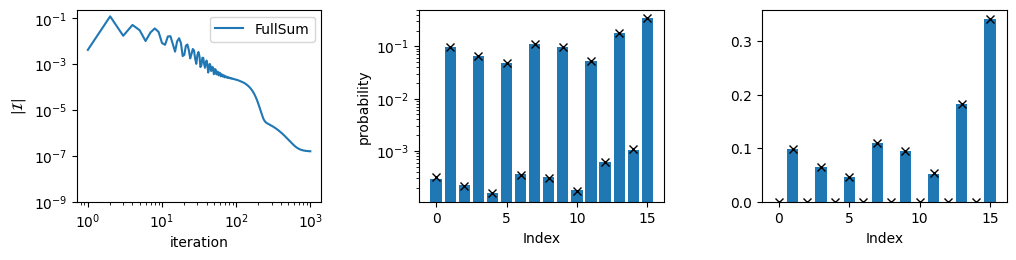

In [9]:
t  = 0.6
it = np.argmin(np.abs(ts-t))
I  = infidelity_mean[it, :]

wf_true = psi_ED[it].full().ravel()
wf_true = wf_true / np.linalg.norm(wf_true)
prob_true = np.abs(wf_true)**2

wf = states[it].to_array()
wf = wf / np.linalg.norm(wf)
prob = np.abs(wf)**2


fig,ax = plt.subplots(1,3, figsize=(12.,2.5), gridspec_kw={"wspace":0.4})
ax[0].plot(np.arange(len(I))+1, I, label="FullSum")
ax[0].legend()
print(f"Initial infidelity: {I[0]:.4e}, Final infidelity: {I[-1]:.4e}")

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylabel(r"$|\mathcal{I}|$")
ax[0].set_xlabel(r"iteration")
ax[0].set_ylim(bottom=1e-9)

for axx in ax[1:]:
    axx.bar(range(len(prob)), prob, color="tab:blue", label="FullSum")
    axx.plot(range(len(prob_true)), prob_true, "xk", label="True")
    axx.set_xlabel('Index')
    
ax[1].set_yscale("log")
ax[1].set_ylabel('probability');